In [1]:
import nmm
import jax.numpy as jnp
from nmm.utils import Qobj as jax_Qobj
import numpy as np

In [2]:
bath=nmm.OverdampedBath(coupling=0.1,cutoff=5,T=1)

In [3]:
t=jnp.linspace(0,20,100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
import contextlib
import time

In [5]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [6]:
sp=jax_Qobj(jnp.array([[0,0],[1,0]]))
sm=jax_Qobj(jnp.array([[0,1],[0,0]]))
sz=jax_Qobj(jnp.array([[1,0],[0,-1]]))
sx=sm+sp
rho0=jax_Qobj(jnp.array([[1,1],[1,1]]))*0.5

In [7]:
import nmm.redfield


In [8]:
cc=nmm.cumulant.csolve(Hsys=sz*0.5,baths=[bath],t=t,Qs=[sx],eps=1e-6)
cc2=nmm.cumulant.csolve(Hsys=sz*0.5,baths=[bath],t=t,Qs=[sx],cython=False,matsubara=True)

In [9]:
import matplotlib.pyplot as plt

In [10]:
with timer("Cumulant solution"):
    ans=cc.evolution(rho0)

Calculating Integrals ...:   0%|          | 0/4 [00:00<?, ?it/s]/home/mcditoos/anaconda3/envs/cumulant/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:447: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
Calculating Integrals ...:  25%|██▌       | 1/4 [00:00<00:00,  5.53it/s]/home/mcditoos/anaconda3/envs/cumulant/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:450: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advi

Cumulant solution: 1.5758228302001953


In [11]:
with timer("Cumulant Matsubara solution"):
    ans2=cc2.evolution(rho0)

Computing Exponential of Generators . . . .: 100%|██████████| 100/100 [00:00<00:00, 14950.29it/s]

Cumulant Matsubara solution: 0.48024630546569824


In [12]:
import qutip as qt

In [13]:
t2=np.linspace(0,10,2)


In [14]:
red=nmm.redfield.redfield(Hsys=qt.sigmaz()*0.5,baths=[bath],t=t,Qs=[qt.sigmax()],eps=1e-2,matsubara=False)
red2=nmm.redfield.redfield(Hsys=qt.sigmaz()*0.5,baths=[bath],t=t,Qs=[qt.sigmax()],matsubara=True)


In [15]:
%timeit red2.generator(10)

2.07 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit red.generator(10)

12.7 s ± 532 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
rho02=qt.Qobj(rho0.data)

In [18]:
with timer("Redfield Matsubara solution"):
    ansr=red2.evolution(rho02)

Redfield Matsubara solution: 0.873227596282959


In [19]:
with timer("Redfield Matsubara solution"):
    ansr2=red2.evolution(rho02)

Redfield Matsubara solution: 0.7211122512817383


In [22]:
def population(states,i,j):
    return [l.data[i,j] for l in states]
def population2(states,i,j):
    return [l[i,j] for l in states]

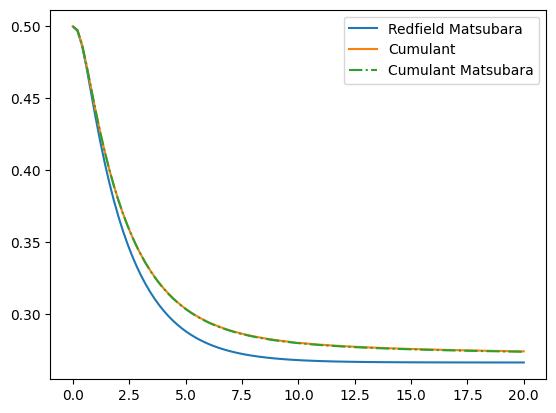

In [23]:
cohcum=population(ans,0,0)
cohcum2=population(ans2,0,0)
states=population2(ansr,0,0)
plt.plot(cc.t,np.abs(states),label="Redfield Matsubara")
plt.plot(cc.t,np.abs(cohcum),label="Cumulant")
plt.plot(cc.t,np.abs(cohcum2),"-.",label="Cumulant Matsubara")
plt.legend()
plt.show()

In [ ]:
from nmm.cumulant.refined import crsolve

In [ ]:
candidate=nmm.refined.crsolve(Hsys=qt.sigmaz()*0.5,baths=[bath],t=t,Qs=[qt.sigmax()],cython=False,matsubara=True)


In [ ]:
with timer("Candidate"):
    ans3=candidate.evolution(rho02)

Calculating Integrals ...:   0%|          | 0/4 [00:00<?, ?it/s]

TypeError: 'float' object is not iterable

In [ ]:
states3=[ans3.y[:,i].reshape(2,2)[0,0] for i in range(len(t))]

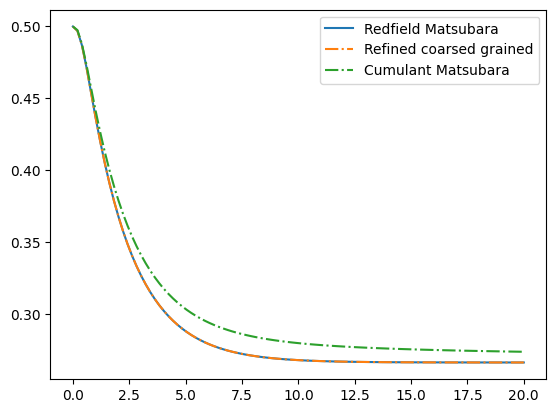

In [ ]:
cohcum=population(ans,0,0)
cohcum2=population(ans2,0,0)
plt.plot(cc.t,np.abs(states),label="Redfield Matsubara")
#plt.plot(cc.t,np.abs(states2),"-.",label="Redfield Non-Matsubara")
plt.plot(cc.t,np.abs(states2),"-.",label="Refined coarsed grained")
#plt.plot(cc.t,np.abs(cohcum),label="Cumulant")
plt.plot(cc.t,np.abs(cohcum2),"-.",label="Cumulant Matsubara")
plt.legend()
plt.show()